In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

In [2]:
file_path = 'stroke.xlsx'
data = pd.read_excel(file_path, sheet_name='data') 

print(data.head())

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi  weight_in_kg  \
0        Private          Urban             228.69  36.6         116.0   
1  Self-employed          Rural             202.21   NaN          86.0   
2        Private          Rural             105.92  32.6          92.0   
3        Private          Urban             171.23  34.5          83.0   
4  Self-employed          Rural             174.12  24.0          63.0   

   height_in_m   smoking_status  stroke  
0         1.78  formerly smoked       1  
1         1.68     never smoked       1  
2         1.68     n

In [3]:
target_variable = 'stroke'
data = data.drop(['id'],axis=1)
input_variables = [col for col in data.columns if col != target_variable]

In [4]:
categorical_attributes = [
    'gender', 'hypertension', 'heart_disease', 'ever_married', 
    'work_type', 'Residence_type', 'smoking_status', 
    'BMI_category','Age_group',
]
numerical_attributes = [
    'age', 'avg_glucose_level', 'bmi', 
    'weight_in_kg', 'height_in_m'
]

In [5]:
missing_values = data.isnull().sum()
print(missing_values)

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  196
weight_in_kg         732
height_in_m          732
smoking_status         0
stroke                 0
dtype: int64


In [6]:
# Handle Missing Values

imputer = KNNImputer(n_neighbors=5)
imputed_values = imputer.fit_transform(data[['age', 'bmi', 'avg_glucose_level']])

data['bmi'] = data['bmi'].fillna(pd.Series(imputed_values[:, 1], index=data.index))

height_median = data['height_in_m'].median()
data['height_in_m'] = data['height_in_m'].fillna(height_median)

weight_median = data['weight_in_kg'].median()
data['weight_in_kg'] = data['weight_in_kg'].fillna(weight_median)

missing_values = data.isnull().sum()
print(missing_values)

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
weight_in_kg         0
height_in_m          0
smoking_status       0
stroke               0
dtype: int64


In [7]:
data.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,weight_in_kg,height_in_m,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,27.608904,82.345988,1.687693,0.048728
std,22.612647,0.296607,0.226063,45.283560,5.730440,17.516730,0.105063,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.100000,11.000000,0.930000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.700000,70.000000,1.620000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,27.700000,81.000000,1.680000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,31.600000,92.000000,1.730000,0.000000
max,82.000000,1.000000,1.000000,271.740000,50.400000,156.000000,1.940000,1.000000


In [8]:
# identify and handle outliers

def detect_and_handle_outliers(df, column):
    Q1 = df[column].quantile(0.25) 
    Q3 = df[column].quantile(0.75) 
    IQR = Q3 - Q1                 
    lower_bound = Q1 - 1.5 * IQR   
    upper_bound = Q3 + 1.5 * IQR  
    
    outliers = (df[column] < lower_bound) | (df[column] > upper_bound)
    
    outlier_count = outliers.sum()
    
    median_value = df[column].median()
    df.loc[outliers, column] = median_value
    
    return df, outlier_count 
    
total_outliers_handled = 0  
for col in numerical_attributes:
    if col in data.columns:  
        data, outliers_handled = detect_and_handle_outliers(data, col)
        total_outliers_handled += outliers_handled 
        print(f"Outliers handled in '{col}': {outliers_handled} outliers")

print(f"Total outliers handled across all columns: {total_outliers_handled}")

print(data[numerical_attributes].describe())

Outliers handled in 'age': 0 outliers
Outliers handled in 'avg_glucose_level': 627 outliers
Outliers handled in 'bmi': 5 outliers
Outliers handled in 'weight_in_kg': 79 outliers
Outliers handled in 'height_in_m': 290 outliers
Total outliers handled across all columns: 1001
               age  avg_glucose_level          bmi  weight_in_kg  height_in_m
count  5110.000000        5110.000000  5110.000000   5110.000000  5110.000000
mean     43.226614          91.490283    27.611076     81.680626     1.675262
std      22.612647          21.201454     5.702182     16.196066     0.086051
min       0.080000          55.120000    11.900000     39.000000     1.520000
25%      25.000000          77.245000    23.700000     71.000000     1.620000
50%      45.000000          91.882500    27.700000     81.000000     1.680000
75%      61.000000         101.295000    31.600000     92.000000     1.710000
max      82.000000         168.680000    42.800000    125.000000     1.890000


In [9]:
# Categorise BMI and Age

def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 25:
        return 'Normal'
    elif 25 <= bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

data['BMI_category'] = data['bmi'].apply(categorize_bmi)

# Create age groups
def categorize_age(age):
    if age < 18:
        return 'Child'
    elif 18 <= age < 65:
        return 'Adult'
    else:
        return 'Elderly'

data['Age_group'] = data['age'].apply(categorize_age)

In [10]:
# Standardize Numerical Variables
scaler = StandardScaler()
scaled_columns = [f"{col}_scaled" for col in numerical_attributes]  
data[scaled_columns] = scaler.fit_transform(data[numerical_attributes])

print(data[scaled_columns].describe())

         age_scaled  avg_glucose_level_scaled    bmi_scaled  \
count  5.110000e+03              5.110000e+03  5.110000e+03   
mean   5.005781e-17              1.696403e-16 -2.697560e-16   
std    1.000098e+00              1.000098e+00  1.000098e+00   
min   -1.908261e+00             -1.715630e+00 -2.755544e+00   
25%   -8.061152e-01             -6.719670e-01 -6.859583e-01   
50%    7.843218e-02              1.850135e-02  1.559620e-02   
75%    7.860701e-01              4.625002e-01  6.996119e-01   
max    1.714845e+00              3.641131e+00  2.663965e+00   

       weight_in_kg_scaled  height_in_m_scaled  
count         5.110000e+03        5.110000e+03  
mean         -3.615286e-17        4.254913e-16  
std           1.000098e+00        1.000098e+00  
min          -2.635504e+00       -1.804481e+00  
25%          -6.595226e-01       -6.422660e-01  
50%          -4.202828e-02        5.506307e-02  
75%           6.372155e-01        4.037276e-01  
max           2.674947e+00        2.4957

In [11]:
# Encode categorical variables
data = pd.get_dummies(
    data,
    columns=categorical_attributes, 
    drop_first=False)

print(data.columns)

Index(['age', 'avg_glucose_level', 'bmi', 'weight_in_kg', 'height_in_m',
       'stroke', 'age_scaled', 'avg_glucose_level_scaled', 'bmi_scaled',
       'weight_in_kg_scaled', 'height_in_m_scaled', 'gender_Female',
       'gender_Male', 'gender_Other', 'hypertension_0', 'hypertension_1',
       'heart_disease_0', 'heart_disease_1', 'ever_married_No',
       'ever_married_Yes', 'work_type_Govt_job', 'work_type_Never_worked',
       'work_type_Private', 'work_type_Self-employed', 'work_type_children',
       'Residence_type_Rural', 'Residence_type_Urban',
       'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes',
       'BMI_category_Normal', 'BMI_category_Obese', 'BMI_category_Overweight',
       'BMI_category_Underweight', 'Age_group_Adult', 'Age_group_Child',
       'Age_group_Elderly'],
      dtype='object')


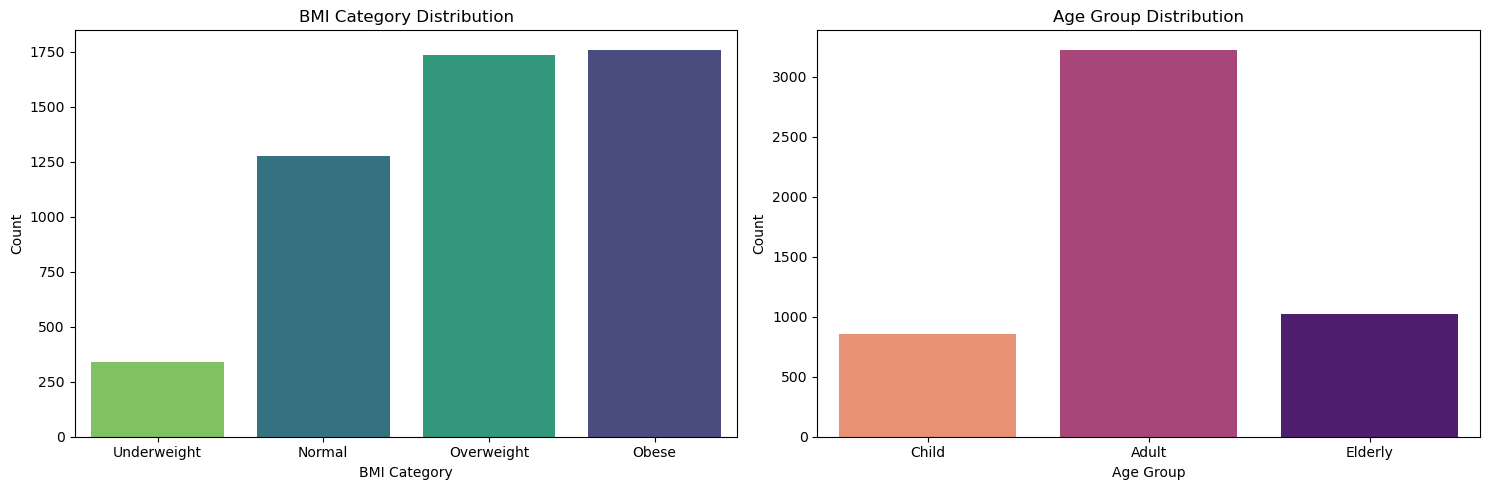

In [12]:
# Visualise the BMI group and Age group
data['BMI_category'] = data[['BMI_category_Underweight', 'BMI_category_Normal', 
                              'BMI_category_Overweight', 'BMI_category_Obese']].idxmax(axis=1).str.replace('BMI_category_', '')
data['Age_group'] = data[['Age_group_Child', 'Age_group_Adult', 'Age_group_Elderly']].idxmax(axis=1).str.replace('Age_group_', '')

bmi_order = ['Underweight', 'Normal', 'Overweight', 'Obese']
age_order = ['Child', 'Adult', 'Elderly']

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(data=data, x='BMI_category', ax=axes[0], hue='BMI_category', palette='viridis', order=bmi_order)
axes[0].set_title('BMI Category Distribution')
axes[0].set_xlabel('BMI Category')
axes[0].set_ylabel('Count')

sns.countplot(data=data, x='Age_group', ax=axes[1], hue='Age_group', palette='magma', order=age_order)
axes[1].set_title('Age Group Distribution')
axes[1].set_xlabel('Age Group')
axes[1].set_ylabel('Count')

plt.tight_layout()

plt.show()

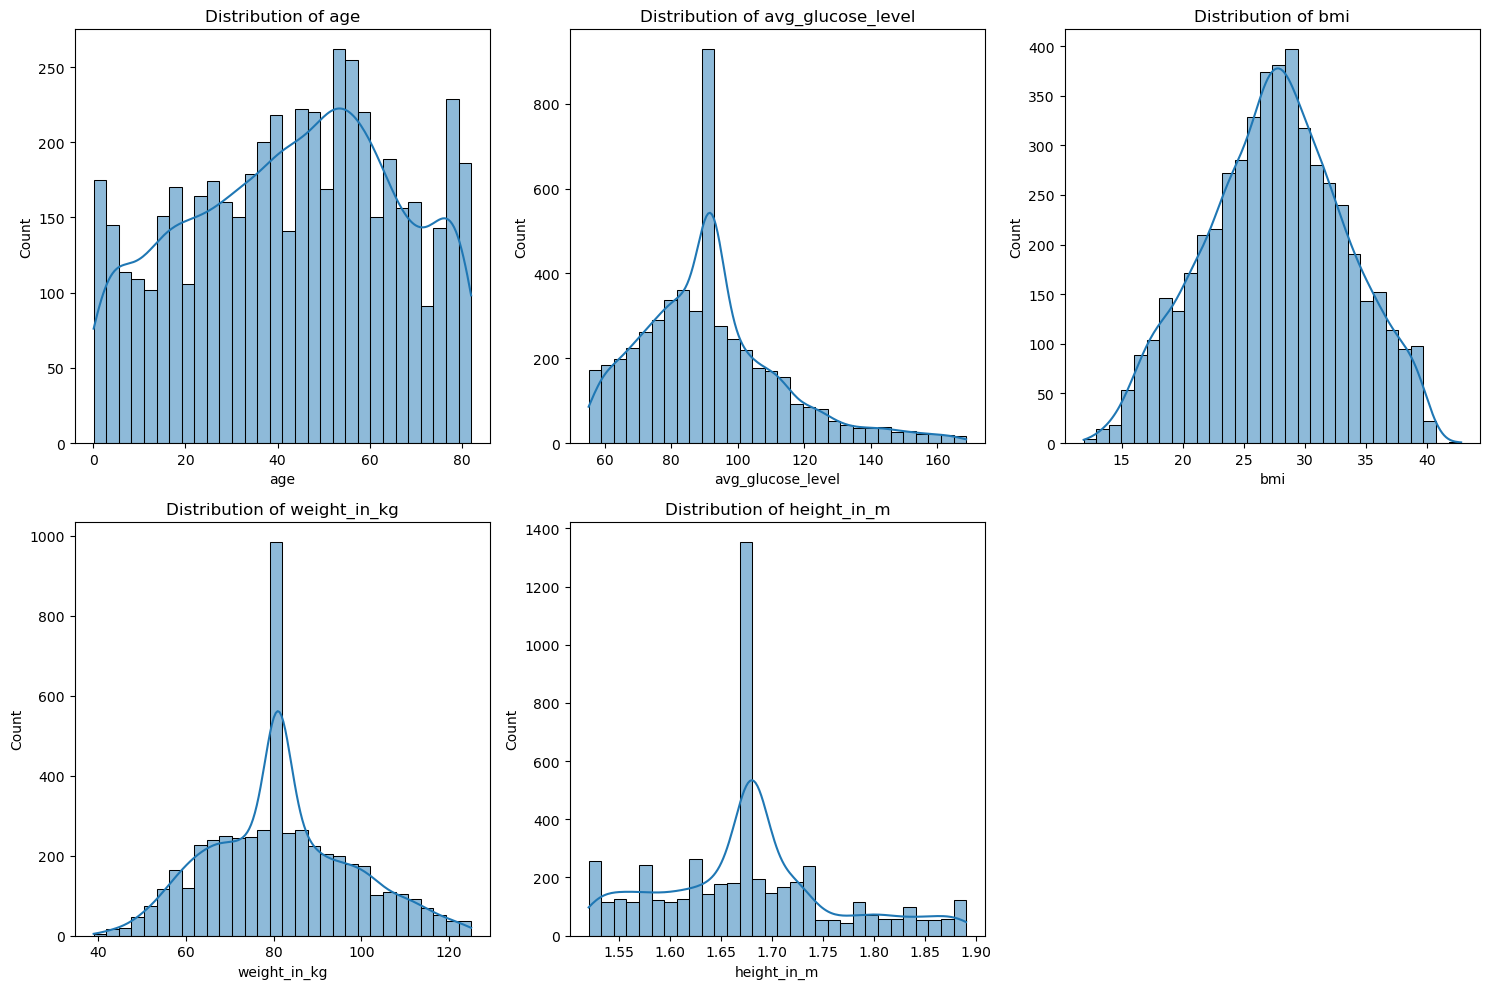

In [13]:
# Visualize the distribution of numerical attributes
plt.figure(figsize=(15, 10))  

for i, column in enumerate(numerical_attributes, 1):
    plt.subplot(2, 3, i)  
    sns.histplot(data[column], kde=True, bins=30)
    plt.title(f"Distribution of {column}")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])  

plt.tight_layout()
plt.show()

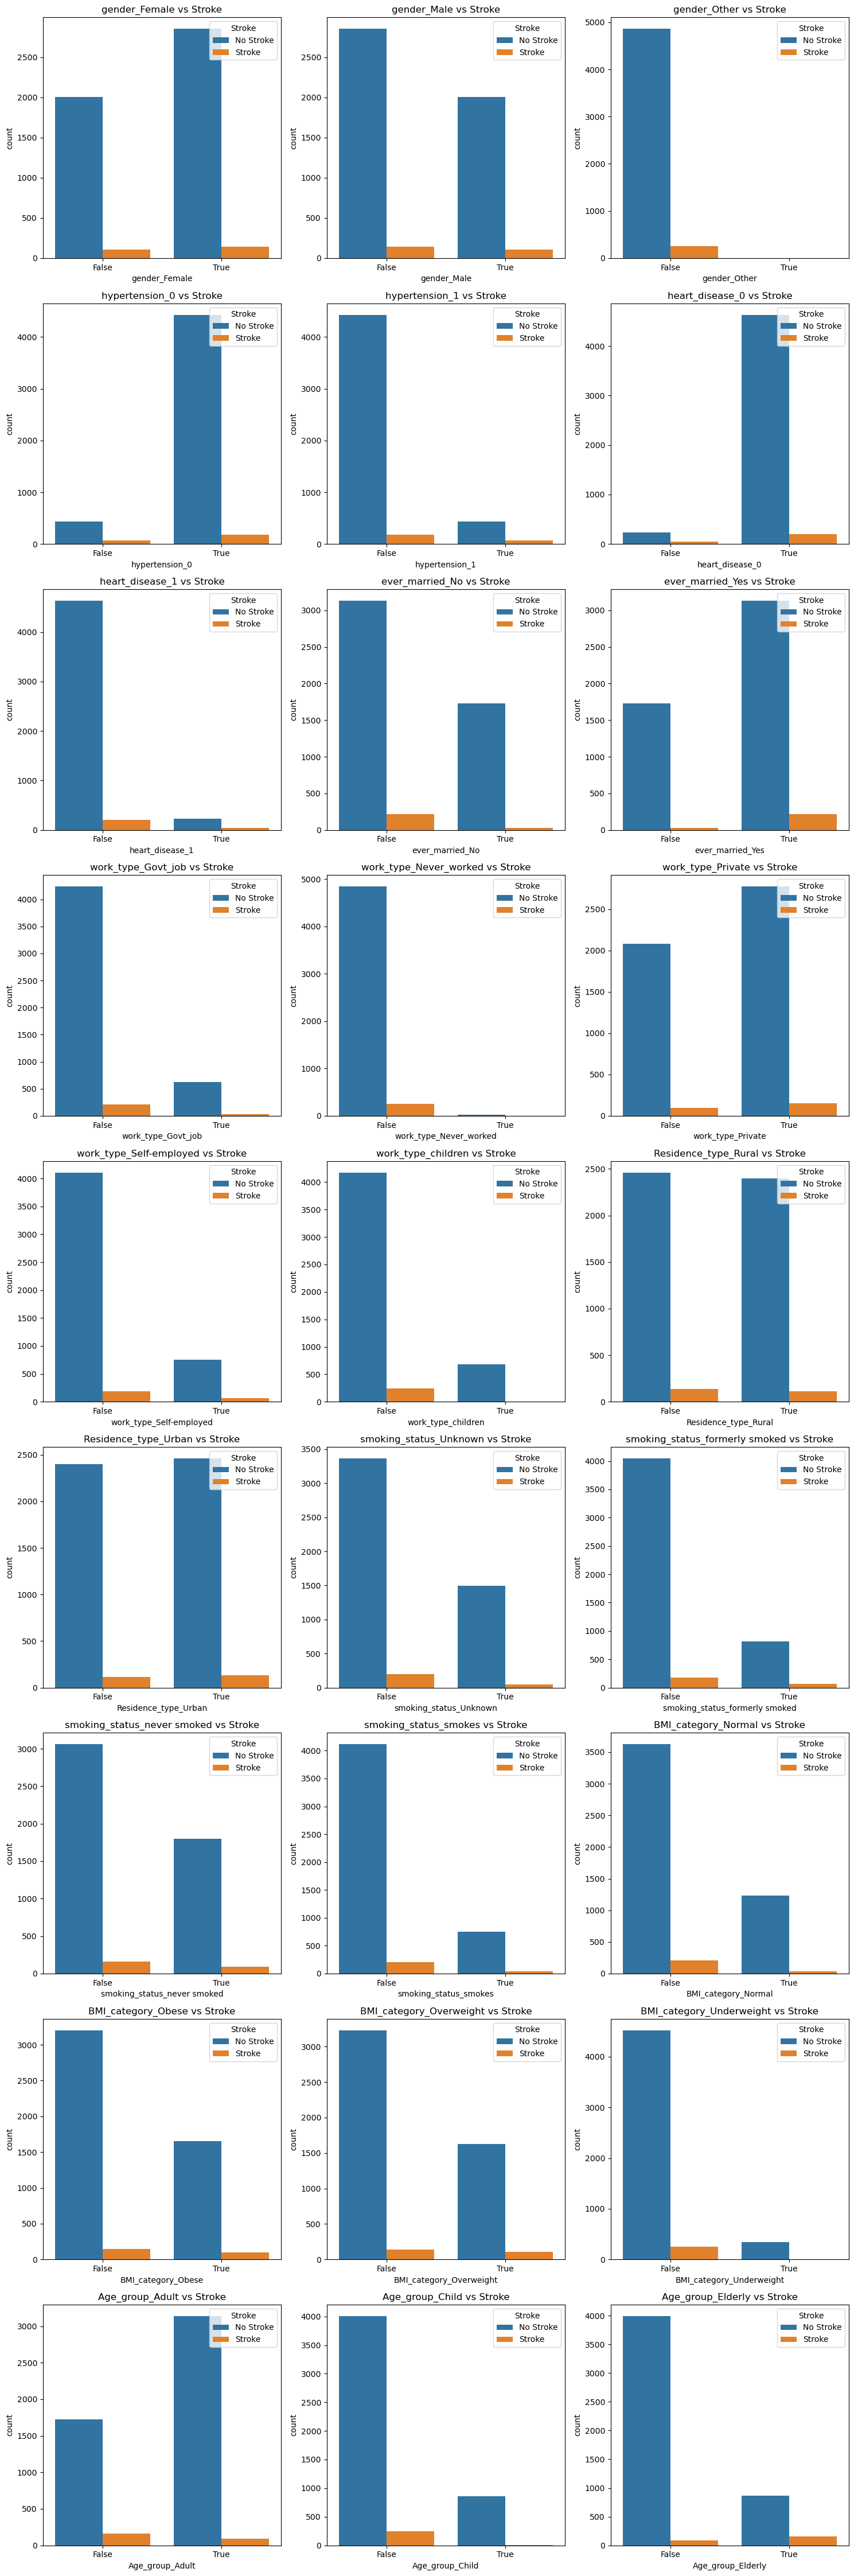

In [14]:
# Visualise the correlations between categorical attributes with the target variable 
encoded_categorical_attributes = [
    'gender_Female','gender_Male', 'gender_Other', 'hypertension_0', 'hypertension_1',
    'heart_disease_0', 'heart_disease_1', 'ever_married_No','ever_married_Yes', 
    'work_type_Govt_job', 'work_type_Never_worked','work_type_Private', 
    'work_type_Self-employed', 'work_type_children','Residence_type_Rural', 
    'Residence_type_Urban','smoking_status_Unknown', 'smoking_status_formerly smoked',
    'smoking_status_never smoked', 'smoking_status_smokes','BMI_category_Normal', 
    'BMI_category_Obese', 'BMI_category_Overweight','BMI_category_Underweight', 
    'Age_group_Adult', 'Age_group_Child','Age_group_Elderly'
]

rows = (len(encoded_categorical_attributes) + 3 - 1) // 3  

fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
axes = axes.flatten()  

for i, cat in enumerate(encoded_categorical_attributes):
    sns.countplot(x=cat, hue=target_variable, data=data, ax=axes[i])
    axes[i].set_title(f"{cat} vs Stroke")
    axes[i].legend(title="Stroke", loc="upper right", labels=["No Stroke", "Stroke"])

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])  # Remove unused axes

plt.tight_layout()
plt.show()

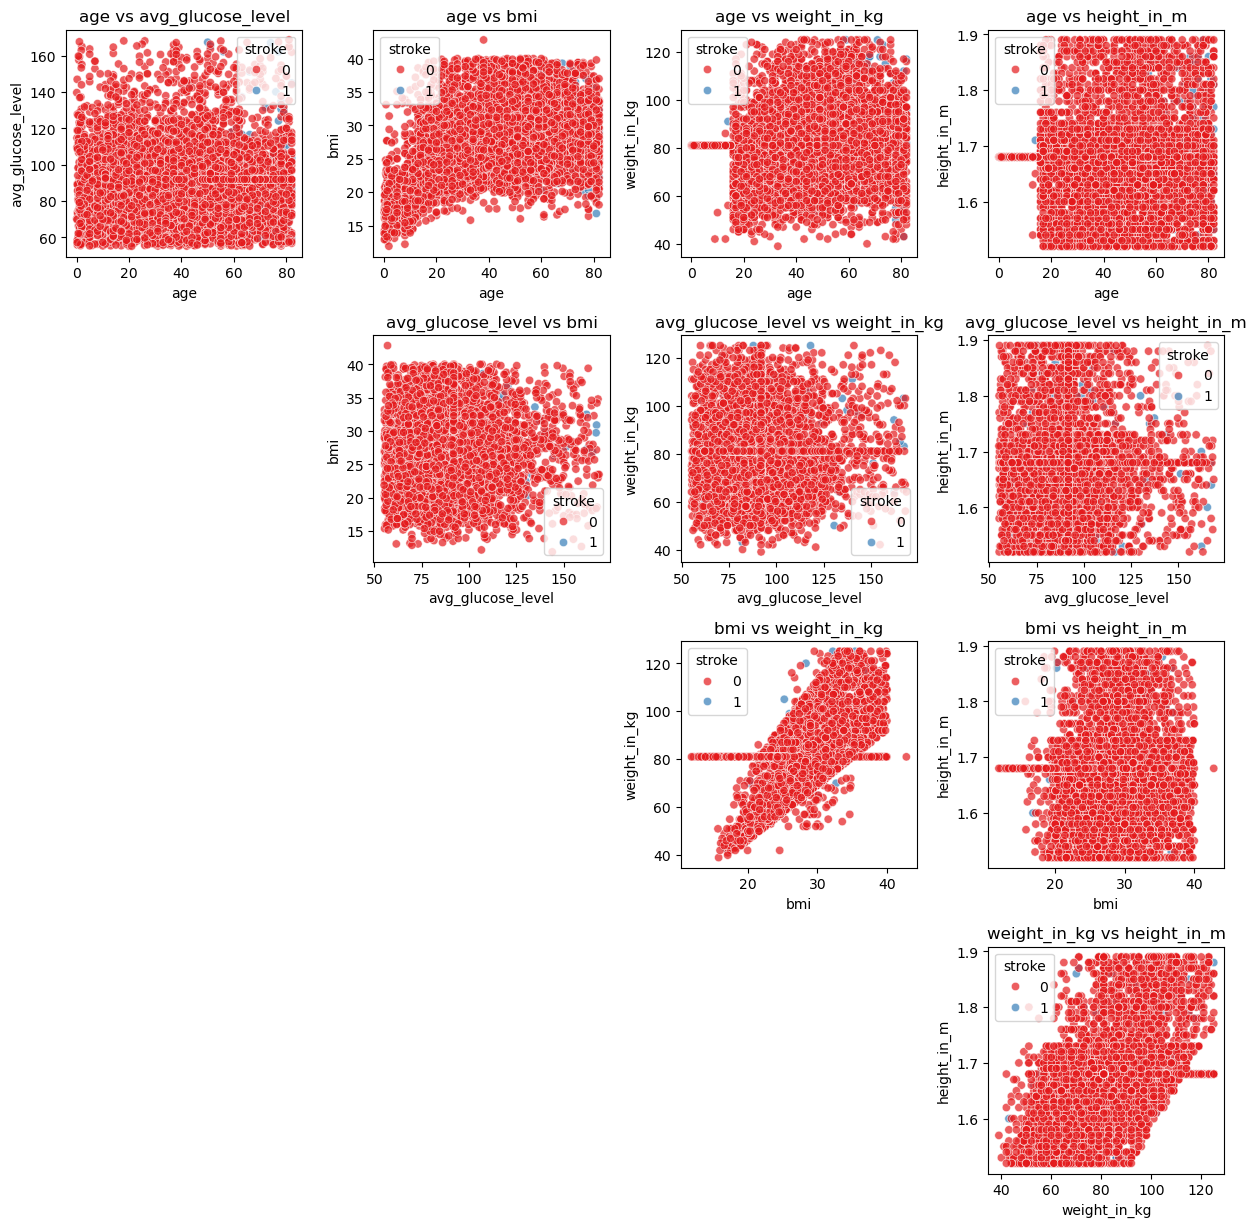

In [15]:
# Visualise the relationship among numerical attributes 
plt.figure(figsize=(15, 15))

for i, col1 in enumerate(numerical_attributes):
    for j, col2 in enumerate(numerical_attributes):
        if i < j:  
            plt.subplot(len(numerical_attributes), len(numerical_attributes), i * len(numerical_attributes) + j + 1)
            sns.scatterplot(x=data[col1], y=data[col2], hue=data[target_variable], palette='Set1', alpha=0.7)
            plt.title(f'{col1} vs {col2}')
            plt.xlabel(col1)
            plt.ylabel(col2)

plt.tight_layout() 
plt.show()

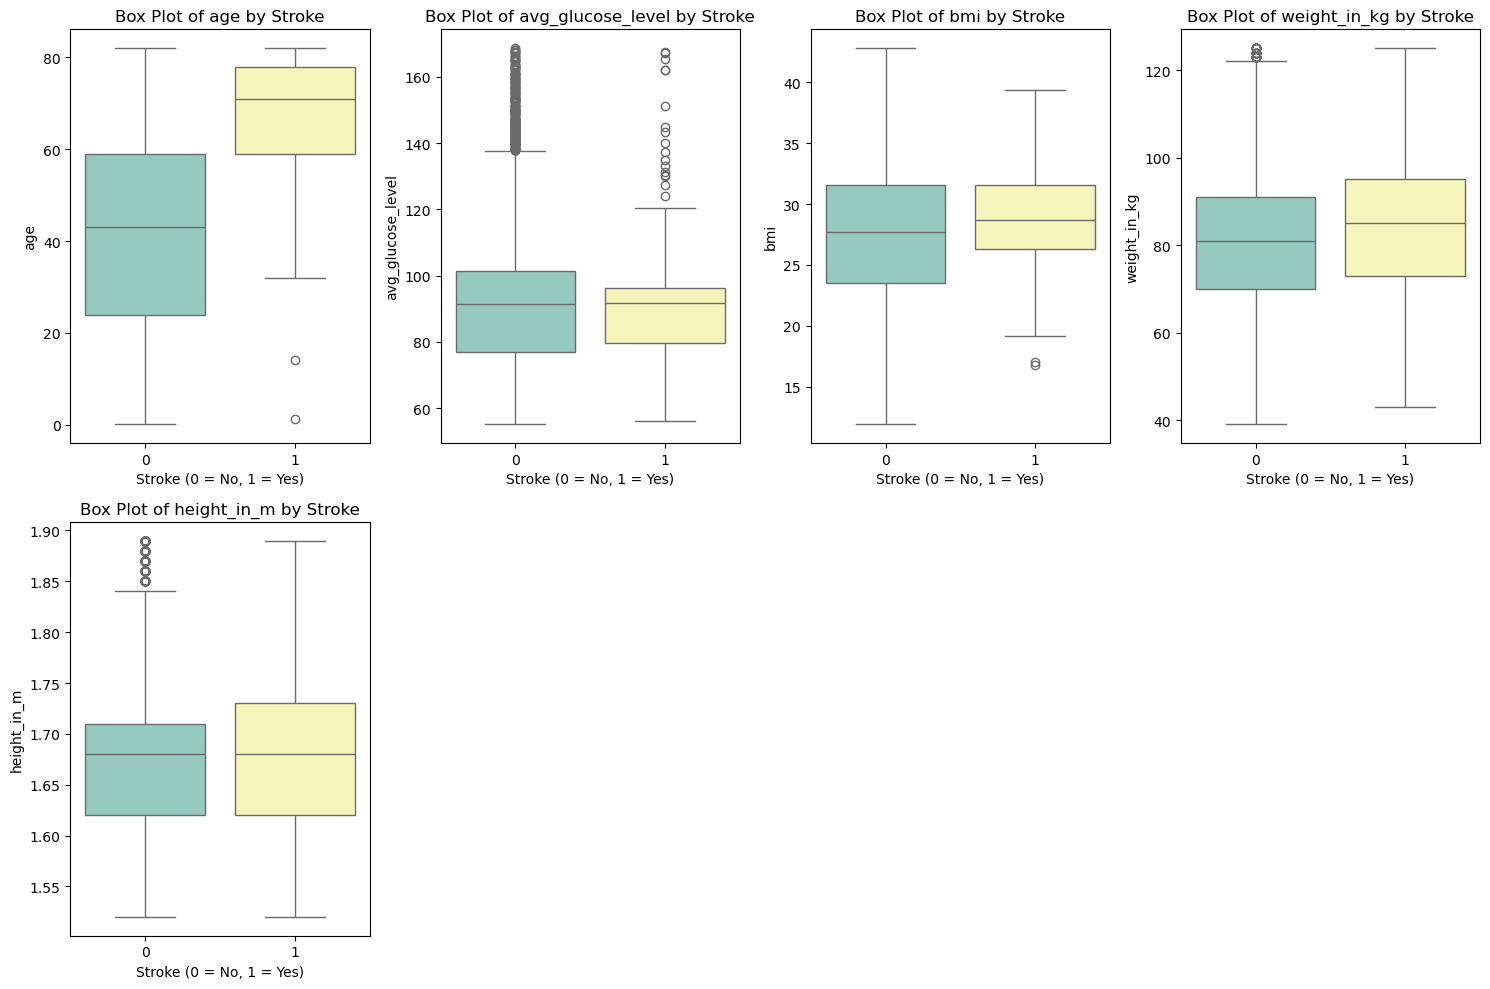

In [16]:
# Visualise the correlation between numerical attributes with the target variable (Box Plot)
plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_attributes, 1):
    plt.subplot(2, 4, i) 
    sns.boxplot(x=data[target_variable], y=data[col], hue=data[target_variable], 
                palette='Set3', legend=False)
    plt.title(f"Box Plot of {col} by Stroke")
    plt.xlabel('Stroke (0 = No, 1 = Yes)')
    plt.ylabel(col)

plt.tight_layout() 
plt.show()

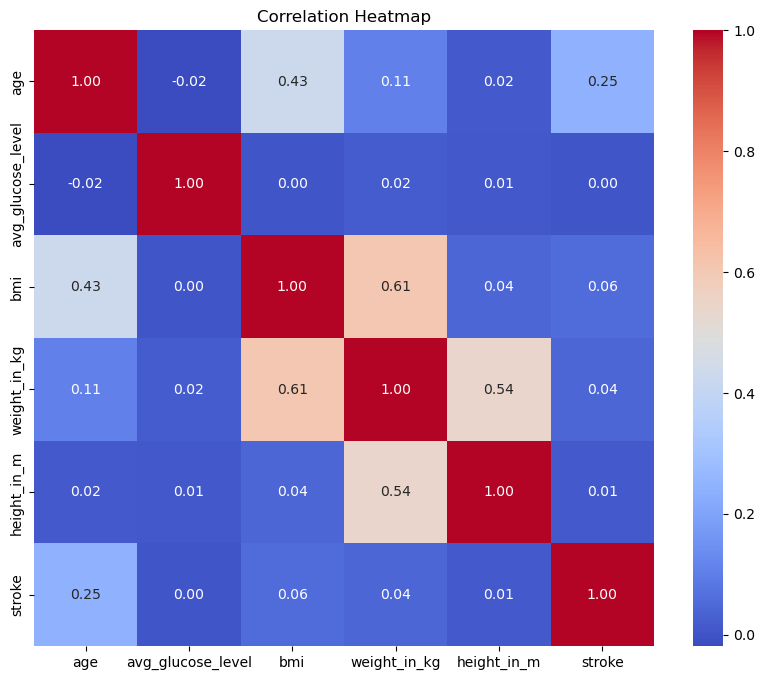

In [17]:
# Visualise the correlation between numerical attributes with the target variable (Heatmap)
numerical_data = data[numerical_attributes + [target_variable]]

correlation_matrix = numerical_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [18]:
# Split the data into features (X) and target (y)
X = data.drop(columns=[target_variable])  
y = data[target_variable]

# Split into training and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [19]:
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("\nSample of scaled training data:")
print(X_train.head())

print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))
print("\nClass distribution in test set:")
print(y_test.value_counts(normalize=True))

Training set shape: (3577, 39)
Test set shape: (1533, 39)

Sample of scaled training data:
       age  avg_glucose_level   bmi  weight_in_kg  height_in_m  age_scaled  \
2226  52.0             107.84  22.0          62.0         1.68    0.388024   
3927  62.0              88.32  36.2          88.0         1.56    0.830297   
3358  81.0              95.49  29.5         100.0         1.84    1.670617   
4152  55.0              73.57  27.9         105.0         1.68    0.520706   
4866  37.0             103.66  36.3          86.0         1.54   -0.275387   

      avg_glucose_level_scaled  bmi_scaled  weight_in_kg_scaled  \
2226                  0.771236   -0.984119            -1.215267   
3927                 -0.149546    1.506400             0.390218   
3358                  0.188671    0.331296             1.131211   
4152                 -0.845321    0.050674             1.439958   
4866                  0.574060    1.523938             0.266719   

      height_in_m_scaled  ...  smokin

In [20]:
# Perform oversampling on training data
oversample = RandomOverSampler(sampling_strategy='minority')
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)

print("New class distribution in training set:")
print(y_train_over.value_counts(normalize=True))

New class distribution in training set:
stroke
0    0.5
1    0.5
Name: proportion, dtype: float64


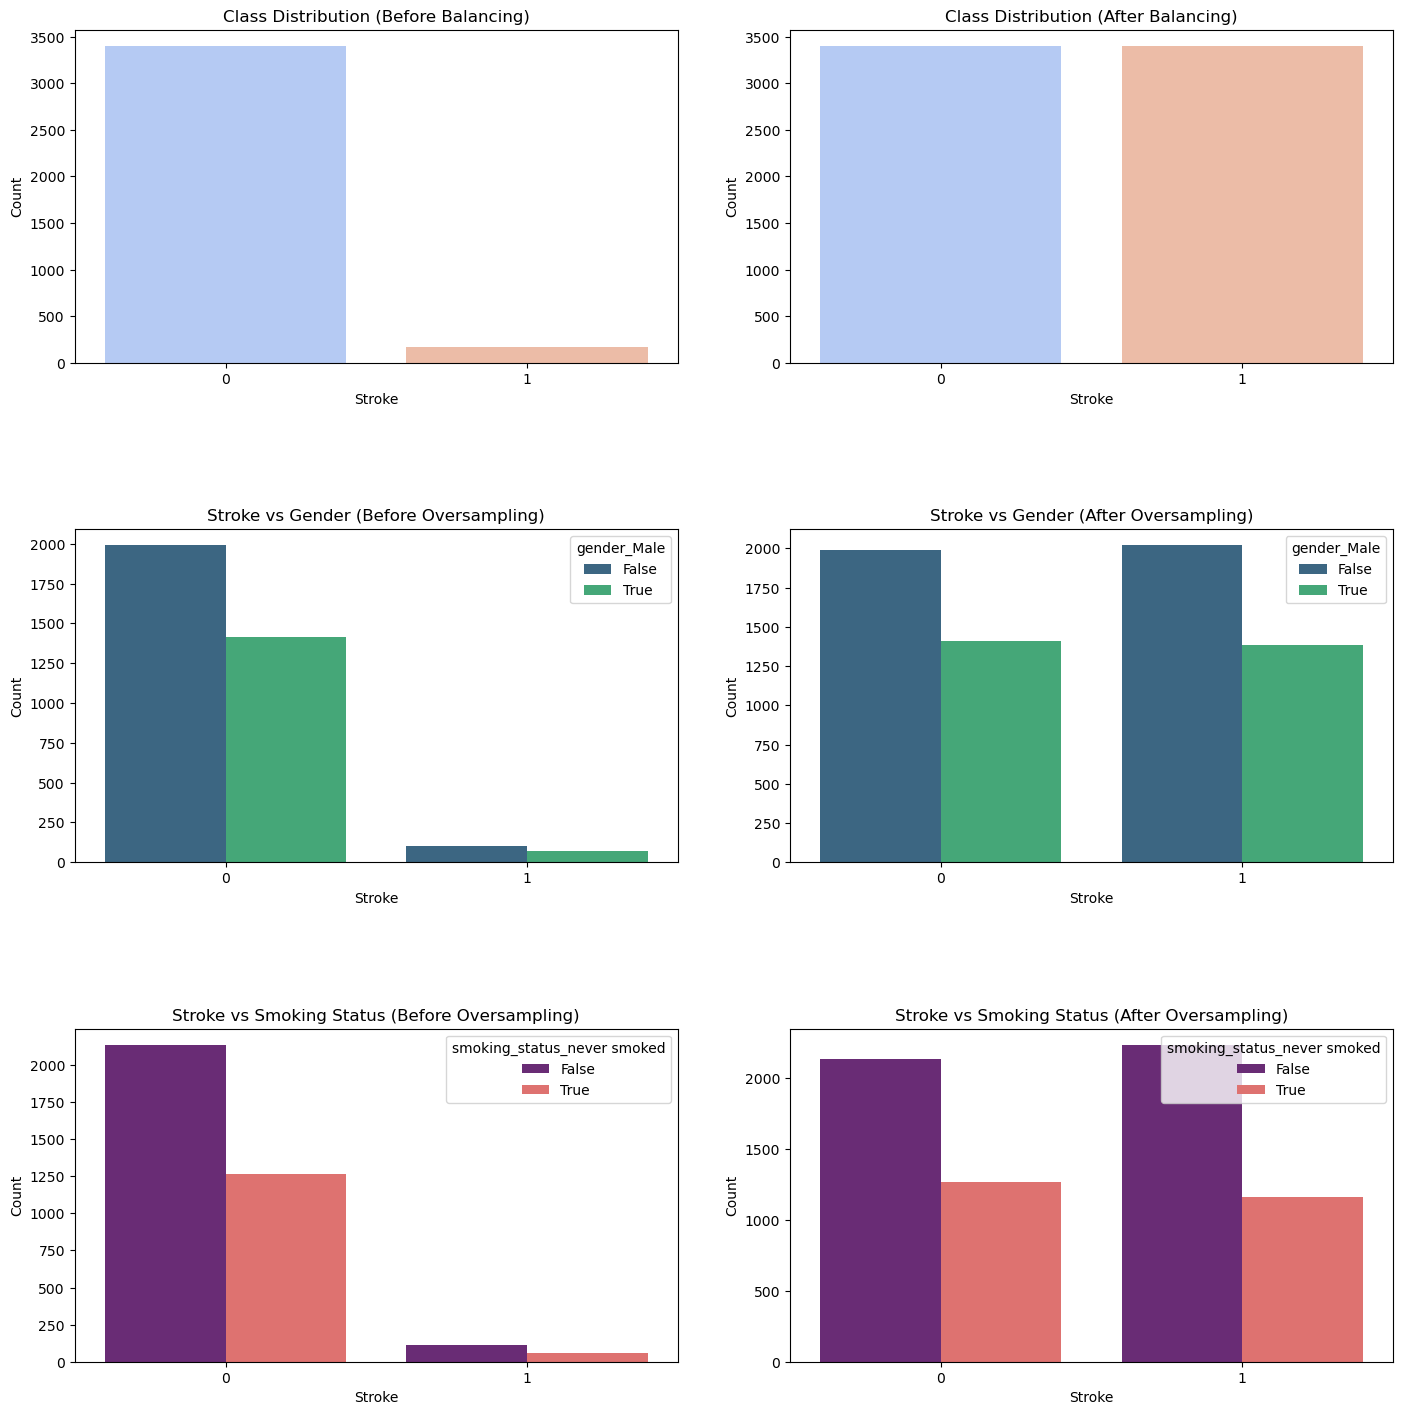

In [21]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))  
fig.tight_layout(pad=5.0) 

X_train_with_target = X_train.copy()  
X_train_with_target['stroke'] = y_train 

X_train_over_with_target = X_train_over.copy()  
X_train_over_with_target['stroke'] = y_train_over 

sns.countplot(x='stroke', data=X_train_with_target, ax=axes[0, 0], palette='coolwarm', hue='stroke', legend=False)
axes[0, 0].set_title('Class Distribution (Before Balancing)')
axes[0, 0].set_xlabel('Stroke')
axes[0, 0].set_ylabel('Count')

sns.countplot(x='stroke', data=X_train_over_with_target, ax=axes[0, 1], palette='coolwarm', hue='stroke', legend=False)
axes[0, 1].set_title('Class Distribution (After Balancing)')
axes[0, 1].set_xlabel('Stroke')
axes[0, 1].set_ylabel('Count')

sns.countplot(x='stroke', hue='gender_Male', data=X_train_with_target, ax=axes[1, 0], palette='viridis')
axes[1, 0].set_title('Stroke vs Gender (Before Oversampling)')
axes[1, 0].set_xlabel('Stroke')
axes[1, 0].set_ylabel('Count')

sns.countplot(x='stroke', hue='gender_Male', data=X_train_over_with_target, ax=axes[1, 1], palette='viridis')
axes[1, 1].set_title('Stroke vs Gender (After Oversampling)')
axes[1, 1].set_xlabel('Stroke')
axes[1, 1].set_ylabel('Count')

sns.countplot(x='stroke', hue='smoking_status_never smoked', data=X_train_with_target, ax=axes[2, 0], palette='magma')
axes[2, 0].set_title('Stroke vs Smoking Status (Before Oversampling)')
axes[2, 0].set_xlabel('Stroke')
axes[2, 0].set_ylabel('Count')

sns.countplot(x='stroke', hue='smoking_status_never smoked', data=X_train_over_with_target, ax=axes[2, 1], palette='magma')
axes[2, 1].set_title('Stroke vs Smoking Status (After Oversampling)')
axes[2, 1].set_xlabel('Stroke')
axes[2, 1].set_ylabel('Count')

plt.subplots_adjust(hspace=0.5)
plt.show()

# PART 5

In [22]:
# Import necessary libraries
from keras.layers import Input
from keras.layers import Dense
from keras.models import Sequential
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

In [23]:
# Initialize models
models = {
    "Decision Tree": make_pipeline(StandardScaler(), DecisionTreeClassifier()),
    "Logistic Regression": make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
    "Naive Bayes": make_pipeline(StandardScaler(), GaussianNB()),
    "Random Forest": make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100)),
    "KNN": make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5))
}

In [24]:
# Dictionary to store model results
model_results = {}

In [25]:
categorical_columns = X_train_over.select_dtypes(include=['object']).columns

In [26]:
# Apply Label Encoding to each categorical column
label_encoder = LabelEncoder()
for col in categorical_columns:
    X_train_over[col] = label_encoder.fit_transform(X_train_over[col])
    X_test[col] = label_encoder.transform(X_test[col])

In [27]:
# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train_over, y_train_over)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob) if y_pred_prob is not None else "N/A"

# Store results
    model_results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC-AUC": roc_auc
    }

In [28]:
# Train and evaluate Artificial Neural Network (ANN)
ann_model = Sequential()
ann_model.add(Input(shape=(X_train_over.shape[1],)))  # Use Input layer to specify input shape
ann_model.add(Dense(32, activation='relu'))
ann_model.add(Dense(16, activation='relu'))
ann_model.add(Dense(1, activation='sigmoid'))
ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

ann_model.fit(X_train_over, y_train_over, epochs=50, batch_size=32, verbose=0, validation_split=0.2)
ann_pred_prob = ann_model.predict(X_test)  # Get the predicted probabilities

# Calculate ANN metrics
ann_pred = (ann_pred_prob > 0.5).astype("int32")
ann_accuracy = accuracy_score(y_test, ann_pred)
ann_precision = precision_score(y_test, ann_pred)
ann_recall = recall_score(y_test, ann_pred)
ann_f1 = f1_score(y_test, ann_pred)

# Calculate ROC-AUC for ANN
ann_roc_auc = roc_auc_score(y_test, ann_pred_prob)

# Store ANN results
model_results["ANN"] = {
    "Accuracy": ann_accuracy,
    "Precision": ann_precision,
    "Recall": ann_recall,
    "F1-Score": ann_f1,
    "ROC-AUC": ann_roc_auc
}

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [29]:
# Summarize results in a DataFrame
results_df = pd.DataFrame(model_results).T
print(results_df)

                     Accuracy  Precision    Recall  F1-Score   ROC-AUC
Decision Tree        0.917808   0.095238  0.080000  0.086957  0.520453
Logistic Regression  0.714286   0.127310  0.826667  0.220641  0.829721
Naive Bayes          0.258969   0.061208  0.986667  0.115265  0.813855
Random Forest        0.947162   0.285714  0.053333  0.089888  0.794193
KNN                  0.853881   0.140097  0.386667  0.205674  0.679319
ANN                  0.810176   0.156051  0.653333  0.251928  0.827938


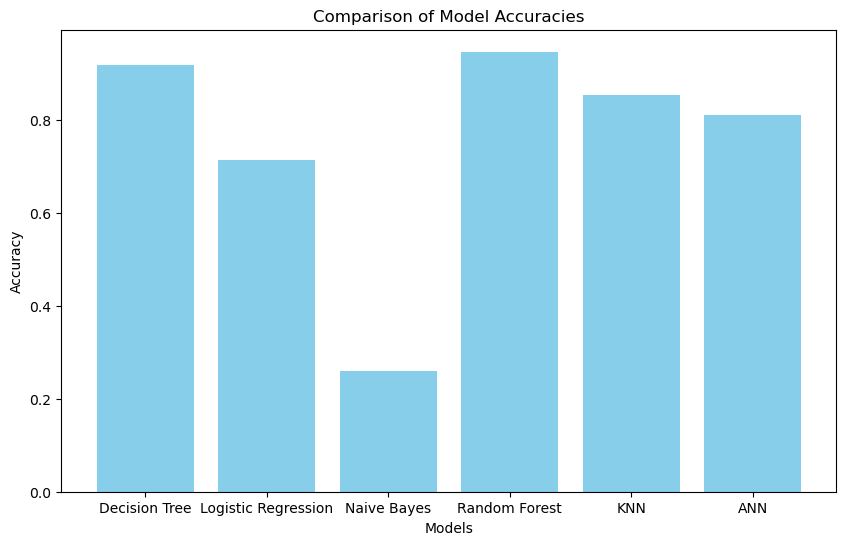

In [30]:
# Plot model accuracies
plt.figure(figsize=(10, 6))
plt.bar(model_results.keys(), [v["Accuracy"] for v in model_results.values()], color='skyblue')
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Comparison of Model Accuracies")
plt.show()

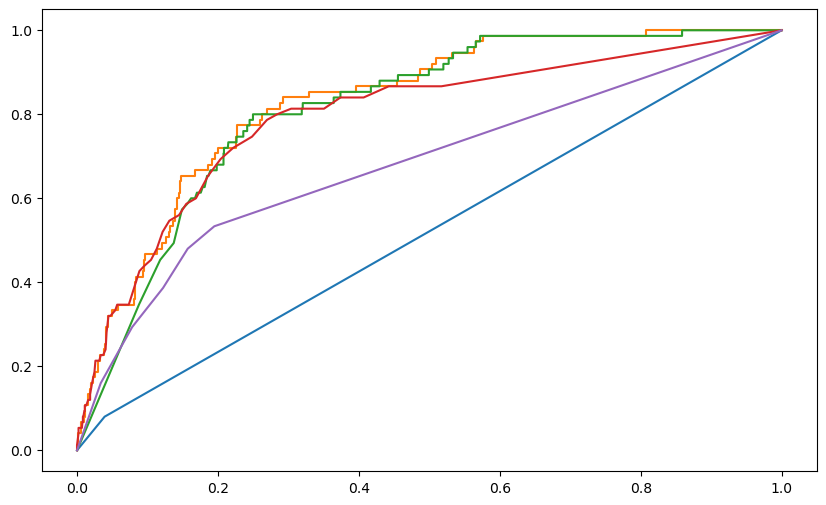

In [31]:
# Plot ROC curves
plt.figure(figsize=(10, 6))
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_pred_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_pred_prob):.2f})")

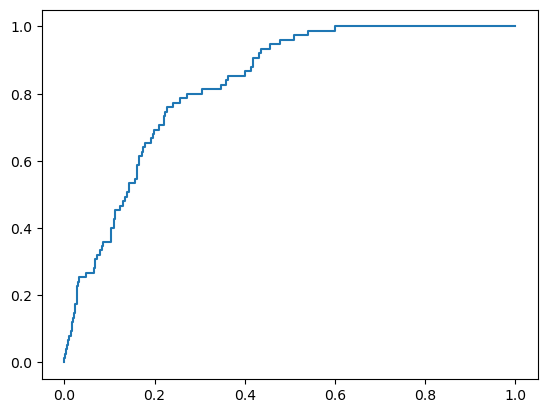

In [32]:
# Plot ROC curve for ANN
fpr, tpr, _ = roc_curve(y_test, ann_pred_prob)
plt.plot(fpr, tpr, label=f"ANN (AUC = {ann_roc_auc:.2f})")

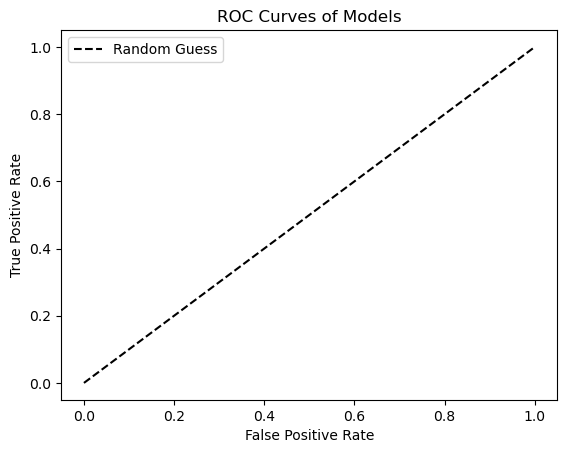

In [33]:
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves of Models")
plt.legend()
plt.show()

In [34]:
# Select and justify the best model
best_model = max(model_results, key=lambda k: model_results[k]["Accuracy"])
print(f"The best model is {best_model} with an accuracy of {model_results[best_model]['Accuracy']:.4f}.")

The best model is Random Forest with an accuracy of 0.9472.


In [35]:
print(data.columns)

Index(['age', 'avg_glucose_level', 'bmi', 'weight_in_kg', 'height_in_m',
       'stroke', 'age_scaled', 'avg_glucose_level_scaled', 'bmi_scaled',
       'weight_in_kg_scaled', 'height_in_m_scaled', 'gender_Female',
       'gender_Male', 'gender_Other', 'hypertension_0', 'hypertension_1',
       'heart_disease_0', 'heart_disease_1', 'ever_married_No',
       'ever_married_Yes', 'work_type_Govt_job', 'work_type_Never_worked',
       'work_type_Private', 'work_type_Self-employed', 'work_type_children',
       'Residence_type_Rural', 'Residence_type_Urban',
       'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes',
       'BMI_category_Normal', 'BMI_category_Obese', 'BMI_category_Overweight',
       'BMI_category_Underweight', 'Age_group_Adult', 'Age_group_Child',
       'Age_group_Elderly', 'BMI_category', 'Age_group'],
      dtype='object')



--- High-Risk Groups Based on Categorical Attributes ---

Analysis for: BMI_category
  BMI_category    stroke
0   Overweight  0.061060
1        Obese  0.057987
2       Normal  0.030564
3  Underweight  0.005900



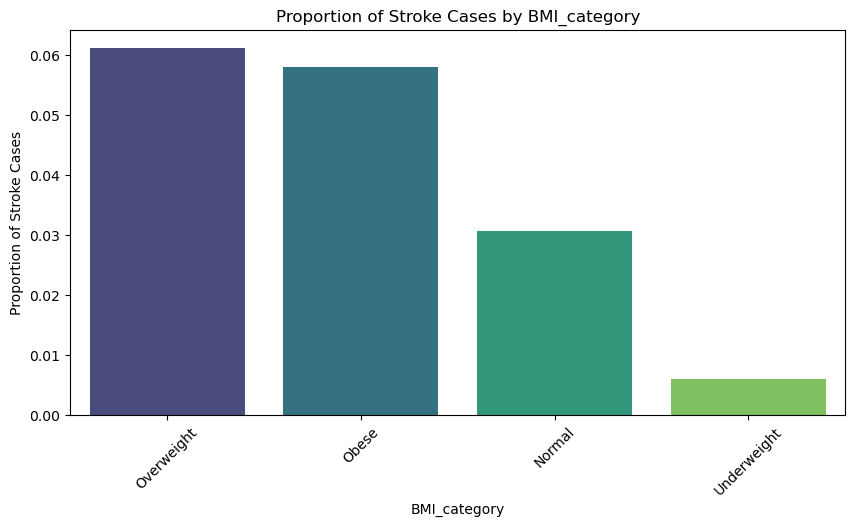

Analysis for: Age_group
  Age_group    stroke
0   Elderly  0.154820
1     Adult  0.027270
2     Child  0.002336



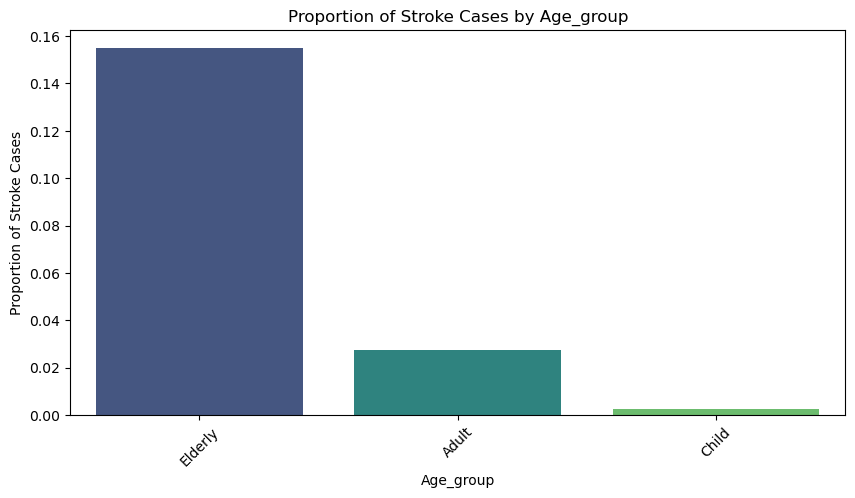


--- High-Risk Groups Based on Numerical Attributes ---

Analysis for: age
Average for Stroke Cases: 67.73
Average for Non-Stroke Cases: 41.97



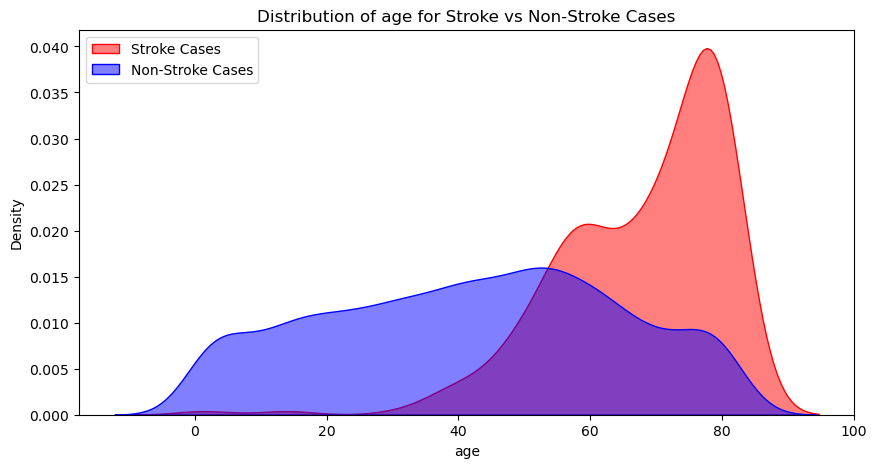

Analysis for: avg_glucose_level
Average for Stroke Cases: 91.83
Average for Non-Stroke Cases: 91.47



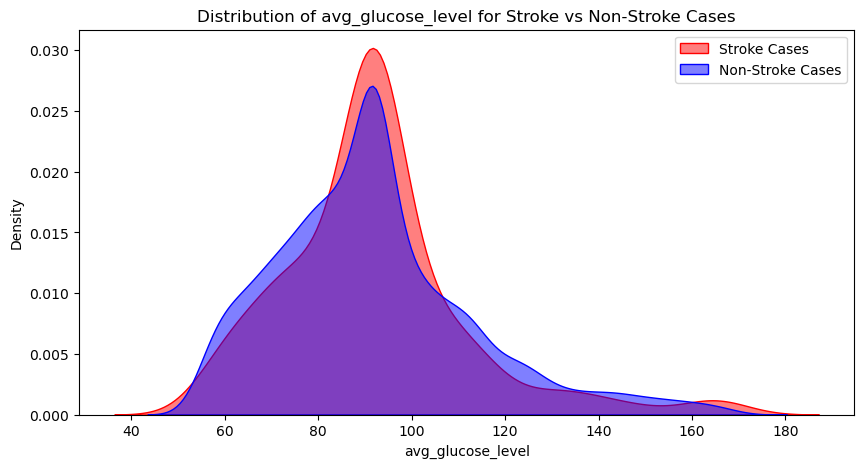

Analysis for: bmi
Average for Stroke Cases: 29.02
Average for Non-Stroke Cases: 27.54



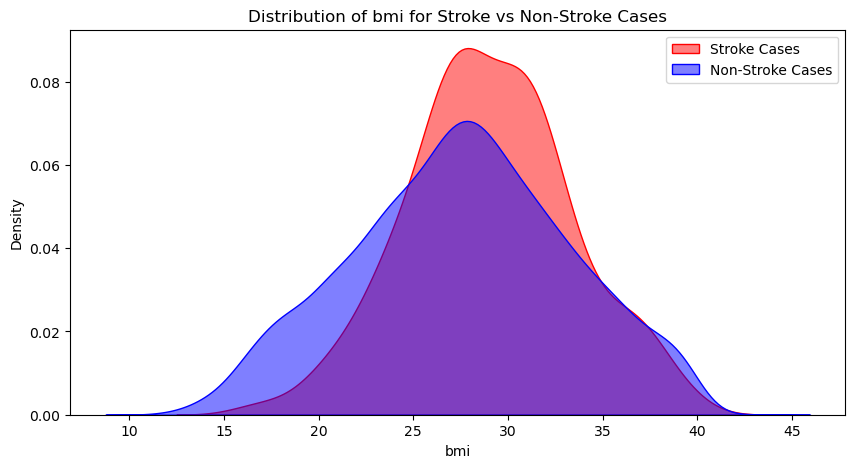

Analysis for: weight_in_kg
Average for Stroke Cases: 84.85
Average for Non-Stroke Cases: 81.52



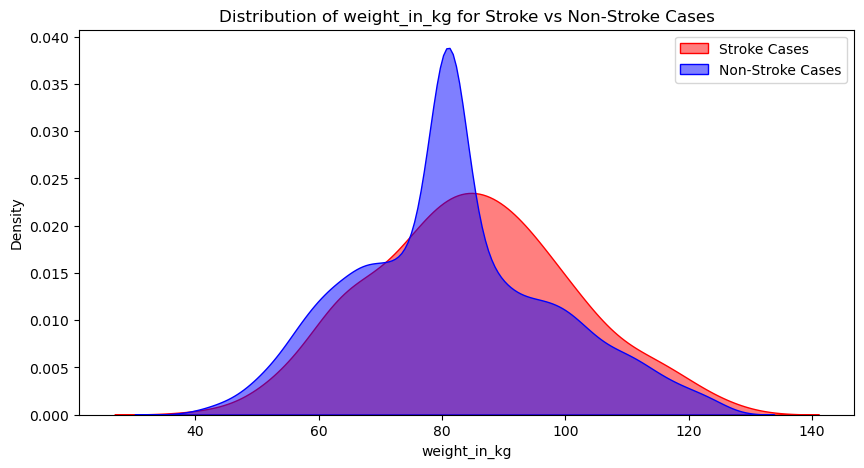

Analysis for: height_in_m
Average for Stroke Cases: 1.68
Average for Non-Stroke Cases: 1.67



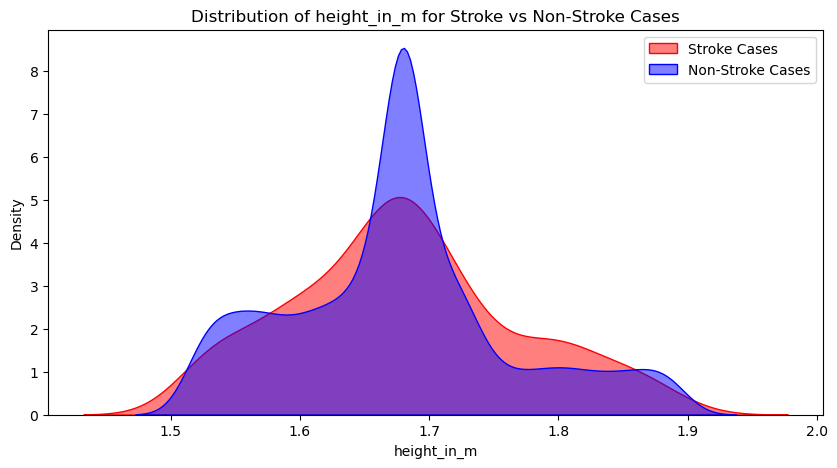

Analysis for: age_scaled
Average for Stroke Cases: 1.08
Average for Non-Stroke Cases: -0.06



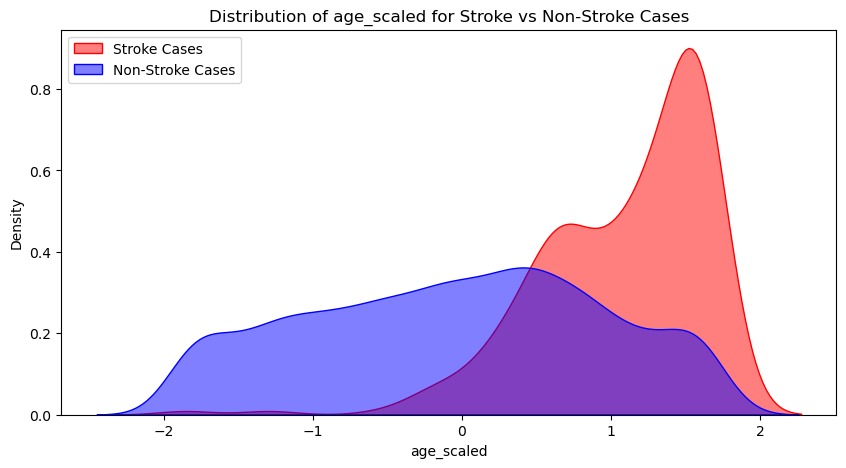

Analysis for: avg_glucose_level_scaled
Average for Stroke Cases: 0.02
Average for Non-Stroke Cases: -0.00



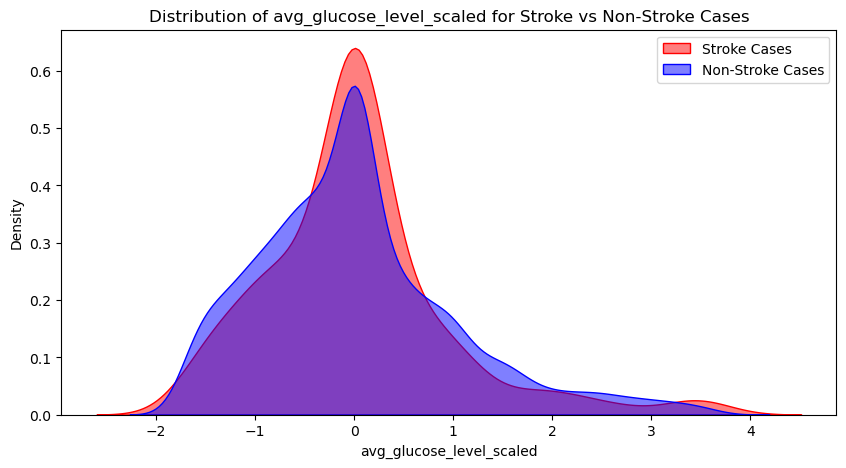

Analysis for: bmi_scaled
Average for Stroke Cases: 0.25
Average for Non-Stroke Cases: -0.01



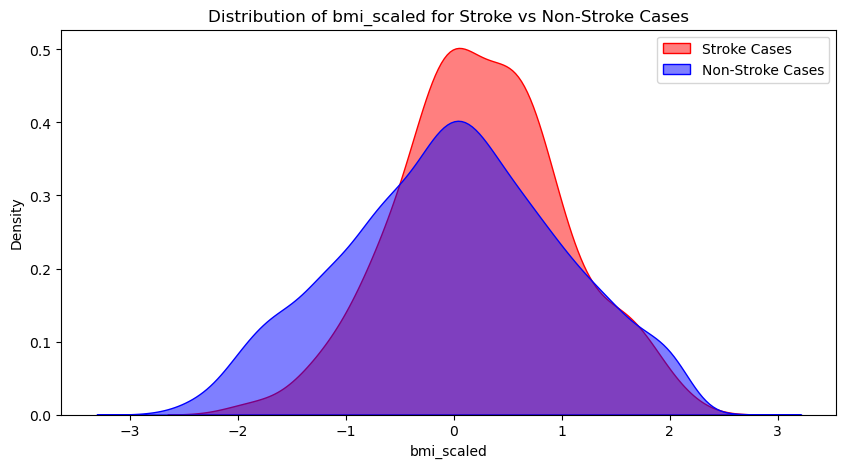

Analysis for: weight_in_kg_scaled
Average for Stroke Cases: 0.20
Average for Non-Stroke Cases: -0.01



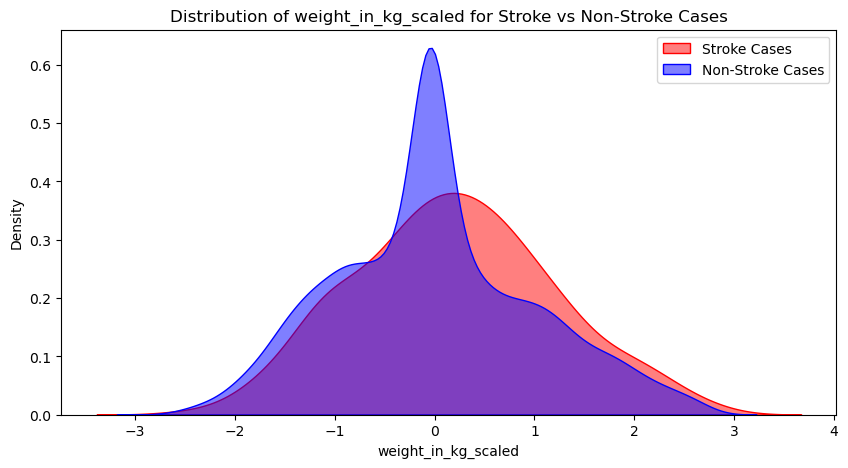

Analysis for: height_in_m_scaled
Average for Stroke Cases: 0.06
Average for Non-Stroke Cases: -0.00



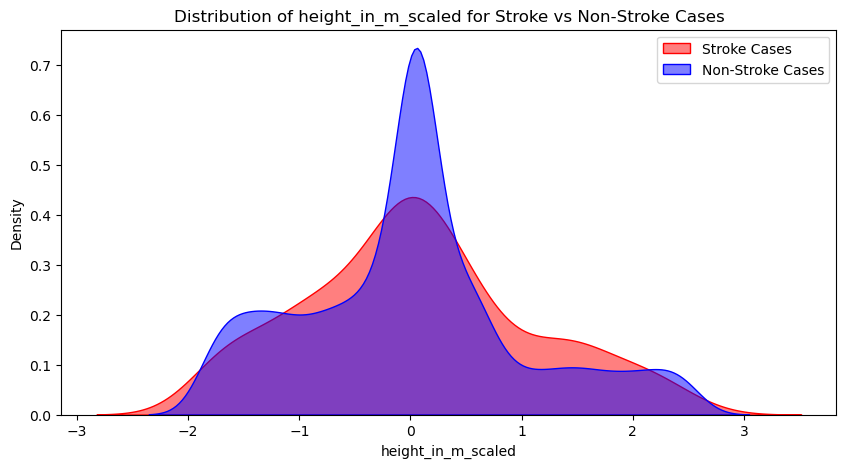


--- Combined Analysis of High-Risk Groups ---

High-risk threshold for age: 78.00
High-risk threshold for avg_glucose_level: 96.16
High-risk threshold for bmi: 31.60
High-risk threshold for weight_in_kg: 95.00
High-risk threshold for height_in_m: 1.73
High-risk threshold for age_scaled: 1.54
High-risk threshold for avg_glucose_level_scaled: 0.22
High-risk threshold for bmi_scaled: 0.70
High-risk threshold for weight_in_kg_scaled: 0.82
High-risk threshold for height_in_m_scaled: 0.64

--- High-Risk Categorical Groups ---

High-risk categories for BMI_category: ['Obese', 'Overweight']
High-risk categories for Age_group: ['Elderly']


In [36]:
def analyze_high_risk_groups(data):

    # Separate stroke cases
    stroke_cases = data[data['stroke'] == 1]
    non_stroke_cases = data[data['stroke'] == 0]

    print("\n--- High-Risk Groups Based on Categorical Attributes ---\n")
    categorical_columns = data.select_dtypes(include=['object', 'category']).columns

    for col in categorical_columns:
        print(f"Analysis for: {col}")
        # Group by categorical columns and calculate the proportion of stroke cases
        group_summary = (
            data.groupby(col)['stroke']
            .mean()
            .sort_values(ascending=False)
            .reset_index()
        )
        print(group_summary)
        print()

        # Visualization
        plt.figure(figsize=(10, 5))
        sns.barplot(data=group_summary, x=col, y='stroke', hue=col, palette="viridis")
        plt.title(f"Proportion of Stroke Cases by {col}")
        plt.ylabel("Proportion of Stroke Cases")
        plt.xlabel(col)
        plt.xticks(rotation=45)
        plt.show()

    print("\n--- High-Risk Groups Based on Numerical Attributes ---\n")
    numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns.drop('stroke')

    for col in numerical_columns:
        print(f"Analysis for: {col}")
        stroke_mean = stroke_cases[col].mean()
        non_stroke_mean = non_stroke_cases[col].mean()
        print(f"Average for Stroke Cases: {stroke_mean:.2f}")
        print(f"Average for Non-Stroke Cases: {non_stroke_mean:.2f}")
        print()

        # Visualization
        plt.figure(figsize=(10, 5))
        sns.kdeplot(stroke_cases[col], label="Stroke Cases", color="red", fill=True, alpha=0.5)
        sns.kdeplot(non_stroke_cases[col], label="Non-Stroke Cases", color="blue", fill=True, alpha=0.5)
        plt.title(f"Distribution of {col} for Stroke vs Non-Stroke Cases")
        plt.xlabel(col)
        plt.ylabel("Density")
        plt.legend()
        plt.show()

    print("\n--- Combined Analysis of High-Risk Groups ---\n")

    # Identify thresholds for high-risk numerical attributes
    high_risk_thresholds = {}
    for col in numerical_columns:
        threshold = stroke_cases[col].quantile(0.75)  # Top 25% of stroke cases
        high_risk_thresholds[col] = threshold
        print(f"High-risk threshold for {col}: {threshold:.2f}")

    print("\n--- High-Risk Categorical Groups ---\n")
    for col in categorical_columns:
        group_summary = (
            data.groupby(col)['stroke']
            .mean()
            .reset_index()
        )
        high_risk_categories = group_summary[group_summary['stroke'] > group_summary['stroke'].mean()][col].tolist()
        print(f"High-risk categories for {col}: {high_risk_categories}")

# Example usage
analyze_high_risk_groups(data)